# World Value Survey Data Processing and Analysis

By Karvie Xia | Feb 2020 

The data was retrieved from the **World Values Survey** data from its webpage http://www.worldvaluessurvey.org/wvs.jsp. The questions revolve around different opinion topics, including trust, work, religion, family, gender equality, and nationalism. 

The analysis would take a special look at what the respondents think about abortion, as it is indicated in question V204:

"*Please tell if abortion can always be justified, never be justified, or something in between.*"

The analysis had three steps listed as follows:

**1. Data processing**: extract the data from its source, transform the data by cleaning duplicates/missing vlues/handling nominal data/others, and save the ready-to-analyze data frame.

**2. Cross-validation set-up**: split train/test dataset and automate the process to train a model capable of classifing respondents' opinions on abortion into 2 categories (1 - justified, 0 - never justified), and report the machine learning evaluation score (accuracy and f_score).

**3. Machine learning comparison**: apply k-NN, logistic regression and Support-Vector-Machine (SVM) models to train the data, select the best model and discuss findings.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression

### 1 Explore and prepare the data

#### 1-1. Load the data

In [2]:
# load the data
wvs = pd.read_csv('wvs.csv.bz2', sep='\t')
wvs.sample(5)

,V2,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,MN_228S8,MN_229A,MN_230A,MN_233A,MN_237B1,MN_249A1,MN_249A3,I_RELIGBEL,I_NORM1,I_VOICE1
8093,112,1,2,2,2,1,2,3,3,1,...,-4,-4,-4,-4,-4,-4,-4,1.0,1.0,0.66
52474,566,1,2,4,1,1,1,1,3,2,...,-4,-4,-4,-4,-4,-4,-4,0.0,0.0,1.00
6770,48,2,1,3,2,1,2,3,2,2,...,1,2,2,5,-3,-1,-1,0.0,0.0,0.33
30252,356,1,1,1,2,4,2,2,1,1,...,-4,-4,-4,-4,-4,-4,-4,0.0,0.0,0.66
36248,400,1,2,2,2,4,1,2,1,2,...,2,-4,-3,-3,-4,1,1,0.0,0.0,0.66


In [3]:
wvs.shape

(90350, 328)

We have 90350 responses and 328 variables.

#### 1-2. Create a summary table

In [4]:
# summary table
wvs.V204.describe()

count    90350.000000
mean         2.946386
std          2.964040
min         -5.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: V204, dtype: float64

In [5]:
# number of non-missing values
wvs[wvs.V204 > 0].shape

(85742, 328)

There are 85742 non-missing values.

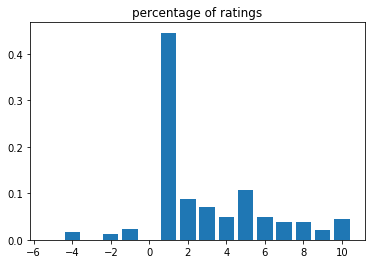

In [6]:
# describe the global opinion about abortion
a = wvs.V204.value_counts(1)
plt.bar(a.index, a.values)
plt.title('percentage of ratings')
plt.show()

The mean of the rating of V204 is around 3, and nearly 45% respondents chose 1. The majority of respondents' answers skewed to "never justifiable" (answer <=5), suggesting that in most regions worldwide, people were against the idea of abortion. 

#### 1-3. Remove missing values

In [7]:
# drop non-positive integers for V204 and V2
wvs = wvs[(wvs['V204']>0)&(wvs['V2']>0)]

In [8]:
# drop null for other variables
wvs = wvs.dropna()

# final numbers
wvs.shape

(79267, 328)

There were 79267 rows and 327 columns left in the dataset.

#### 1-4. Create a binary variable 

In [9]:
wvs['abortion'] = wvs.V204>3
wvs = wvs.drop(columns = 'V204')

In [10]:
wvs.loc[wvs['abortion'] == True,'abortion']=1
wvs.loc[wvs['abortion'] == False,'abortion']=0

In [11]:
wvs.abortion.value_counts()

0    50435
1    28832
Name: abortion, dtype: int64

#### 1-5. Compute correlation table

In [12]:
x = wvs.corr(method = 'pearson')

In [13]:
# compute the abosolute value of pearson correlation
corr = abs(x['abortion'])

In [14]:
# sort the absolute values descendingly
corr.sort_values(ascending = False)

abortion    1.000000
V205        0.548653
V203        0.485419
V206        0.446394
V207        0.418271
              ...   
V7          0.003503
V103        0.003465
V17         0.001757
V125_06     0.000761
V113        0.000752
Name: abortion, Length: 328, dtype: float64

There are several variables having large correlation factors. Defining strong correlation by setting the threshold |r| > 0.3:

In [15]:
corr[corr>0.3]

V9          0.314117
V152        0.315280
V203        0.485419
V205        0.548653
V206        0.446394
V207        0.418271
abortion    1.000000
Name: abortion, dtype: float64

Variables that have strong correlation with abortion represent:

**V9**: important in life: religion

**V152**: how important is God in your life

**V203**: justifiable: homosexuality

**V205**: justifiable: divorce

**V207**: justifiable: suicide

Correlated variables are strongly related to religion reasons, which could lead to different but strong opinions on minor groups (homosexuality), relationships (divorce) and abnormal behavior (suicide). 

#### 1-6. Country dummies

In [16]:
wvs2 = wvs.rename({'V2':'Country'},axis='columns')

In [17]:
wvs3 = pd.get_dummies(wvs2, columns=['Country'])

In [18]:
wvs3.shape

(79267, 385)

Now the dataset has 79267 rows and 385 columns.

In [19]:
# find out country-generated dummies using wildcard
ctryclm = [col for col in wvs3.columns if 'Country' in col]

In [20]:
print(len(ctryclm))

58


There were 58 country dummies.

In [21]:
# remove one of these dummies
wvs_clean = wvs3.drop(['Country_887'],axis=1)

In [22]:
wvs_clean

,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,Country_724,Country_752,Country_764,Country_780,Country_788,Country_792,Country_804,Country_840,Country_858,Country_860
0,1,1,1,-2,1,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2,3,4,2,2,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2,4,2,1,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,1,1,3,4,3,1,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,2,1,1,1,3,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90345,1,3,2,4,1,1,3,3,2,1,...,0,0,0,0,0,0,0,0,0,0
90346,1,1,1,3,1,1,3,1,2,1,...,0,0,0,0,0,0,0,0,0,0
90347,1,2,1,3,1,1,3,3,2,1,...,0,0,0,0,0,0,0,0,0,0
90348,1,2,2,3,1,1,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0


### 2 Implement Cross-validation

In [23]:
# define my k-CV function
def kCV(k, X, y, model):
    #select kth index & repeat k times by setting n_splits = k
    #shuffle the dataset by setting shuffle=True
    kf = KFold(n_splits=k,shuffle=True, random_state=1)
    
    score = []
    
    #generate train/test index
    for train_index, test_index in kf.split(X):
    #generate Xtrain/test, ytrain/test applying the index
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    #model fit
        val = model.fit(X_train, y_train)
        y_pred = val.predict(X_test)
        score.append(val.score(X_test, y_test))
        
    #print result for the k-times validation and the average
    print('score for k-CV:', score)
    print('avg k-CV accuracy:', sum(score)/len(score))
    print('f_score:', f1_score(y_test, y_pred, average='weighted'))

### 3 Find the best model

In [24]:
X = wvs_clean.drop('abortion',axis=1)
y = wvs_clean['abortion']

In [25]:
#sub set X and y 
dX = X.sample(5000)
dy = y.sample(5000)

#### 3-1. k-NN

**1 try different k**

In [26]:
#k=1
knn1 = KNeighborsClassifier(n_neighbors=1)
kCV(5, dX, dy, knn1)

score for k-CV: [0.529, 0.549, 0.542, 0.556, 0.542]
avg k-CV accuracy: 0.5436
f_score: 0.5439364429896344


In [27]:
#k=5
knn5 = KNeighborsClassifier(n_neighbors=5)
kCV(5, dX, dy, knn5)

score for k-CV: [0.578, 0.576, 0.572, 0.574, 0.571]
avg k-CV accuracy: 0.5741999999999999
f_score: 0.5486290822014437


In [28]:
#k=10
knn10 = KNeighborsClassifier(n_neighbors=10)
kCV(5, dX, dy, knn10)

score for k-CV: [0.615, 0.622, 0.593, 0.604, 0.605]
avg k-CV accuracy: 0.6078
f_score: 0.5302805867126833


**2 try with normalized data**

In [29]:
dXN1 = pd.DataFrame(normalize(dX, norm='l1', axis=0))
kCV(5, dXN1, dy, knn10)

score for k-CV: [0.606, 0.606, 0.616, 0.606, 0.61]
avg k-CV accuracy: 0.6087999999999999
f_score: 0.5388421052631579


**3 best k-NN model**

According to the above result, the best model should be k=10 with normalized data, as it has the highest k-CV accuracy 0.609 and the highest f_score 0.547. Here present the result using *k-NN(k=10)* model.

In [30]:
XN1 = pd.DataFrame(normalize(X, norm='l1', axis=0))
kCV(5, XN1, y, knn10)

score for k-CV: [0.7985366469029898, 0.7989151002901476, 0.8007317227023276, 0.8041380180407494, 0.8021194726550179]
avg k-CV accuracy: 0.8008881921182465
f_score: 0.7963414985547022


#### 3-2. Logistic regression

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
#with a subset of the whole dataset
lr = LogisticRegression()
kCV(5, dX, dy, lr)

score for k-CV: [0.597, 0.611, 0.593, 0.582, 0.594]
avg k-CV accuracy: 0.5953999999999999
f_score: 0.5543019800257508


#### 3-3. SVM

In [33]:
#sub set X and y 
dXS = X.sample(1000)
dyS = y.sample(1000)

**1 test linear kernel**

In [34]:
svm_l = SVC(kernel='linear')
kCV(5, dXS, dyS, svm_l)

score for k-CV: [0.5, 0.57, 0.55, 0.56, 0.55]
avg k-CV accuracy: 0.5459999999999999
f_score: 0.5537644787644788


**2 test polynominal kernel**

In [35]:
#degree=1
svm_p1 = SVC(kernel='poly',degree=1,gamma='auto')
kCV(5, dXS, dyS, svm_p1)

score for k-CV: [0.615, 0.585, 0.585, 0.595, 0.63]
avg k-CV accuracy: 0.602
f_score: 0.5965956112852664


In [36]:
#degree=8
svm_p8 = SVC(kernel='poly',degree=8,gamma='auto')
kCV(5, dXS, dyS, svm_p8)

score for k-CV: [0.51, 0.525, 0.53, 0.535, 0.54]
avg k-CV accuracy: 0.528
f_score: 0.5350802139037433


**3 test radial kernel**

In [37]:
#gamma = 2
svm_r1 = SVC(kernel='rbf',gamma= 2)
kCV(5, dXS, dyS, svm_r1)

score for k-CV: [0.65, 0.655, 0.62, 0.64, 0.645]
avg k-CV accuracy: 0.6420000000000001
f_score: 0.50580547112462


In [38]:
#gamma = 0.1
svm_r2 = SVC(kernel='rbf',gamma= 0.1)
kCV(5, dXS, dyS, svm_r2)

score for k-CV: [0.65, 0.655, 0.62, 0.64, 0.645]
avg k-CV accuracy: 0.6420000000000001
f_score: 0.50580547112462


**4 test sigmoid kernel**

In [39]:
#gamma = 2
svm_s1 = SVC(kernel='sigmoid',gamma= 2)
kCV(5, dXS, dyS, svm_s1)

score for k-CV: [0.65, 0.655, 0.62, 0.64, 0.645]
avg k-CV accuracy: 0.6420000000000001
f_score: 0.50580547112462


In [40]:
#gamma = 0.1
svm_s2 = SVC(kernel='sigmoid',gamma= 0.1)
kCV(5, dXS, dyS, svm_s2)

score for k-CV: [0.65, 0.655, 0.62, 0.64, 0.645]
avg k-CV accuracy: 0.6420000000000001
f_score: 0.50580547112462


**5 why high accuracy and low f-score?**

This phenomenon happens when the class in the dataset is **imbalanced**. 

In this case, there are more people thinking that abortion is not justifiable. If the model predicts and classifies most cases to be "0" (not support abortion), the accuracy rate would be naturally higher. 

However, the model's ability to identify relevant cases may not be as high. 

**6 present the model result**

The two sigmoid adn the two radial kernels share the same result with the highest **k-CV accuracy socre 0.626** and the lowest **f_score 0.5312**. 

The other one that has the highest f_score is the linear, with an **accuracy socre 0.542** and a **f_score 0.593**

#### 3-4. Compare models

(1) The best performed model in terms of accuracy is the SVM radial/sigmoid model given either gamma = 0.1 or 2. It reaches the highest accuracy 0.626.

The best performed model in terms of F-score is the SVM linear model. It reaches the highest score 0.593.

The logistic regression model is the fastest, while the SVM methods seem to never complete calculation after including the entire dataset. 

(2) From my perspective, I would prefer the **SVM polynominal kernel model with degree=1**. Although it doesn't have the highest accuracy/F-score, both values are relatively high **(accuracy=0.591, F_score=0.587)**, so I imply that this model may give a relatively more reliable result.

### 4 Does "Country" play a role in the prediction?

**1 best ML model with country dummies (sample=1000)**

In [41]:
#repeat previous computation
svm_p1 = SVC(kernel='poly',degree=1,gamma='auto')
kCV(5, dXS, dyS, svm_p1)

score for k-CV: [0.615, 0.585, 0.585, 0.595, 0.63]
avg k-CV accuracy: 0.602
f_score: 0.5965956112852664


**2 ML model without country dummies (sample=1000)**

In [64]:
#prepare the dataset removing all country dummies
clm = [col for col in X.columns if 'Country' not in col]
X2 = X.loc[:,clm]
dX2S = X2.sample(1000)

In [65]:
#compute stats 
svm_p1_2 = SVC(kernel='poly',degree=1,gamma='auto')
kCV(5, dX2S, dyS, svm_p1_2)

score for k-CV: [0.61, 0.55, 0.575, 0.57, 0.57]
avg k-CV accuracy: 0.575
f_score: 0.5273490613901572


**3 findings**

From the above result, it seems that models with the country information have a higher k-CV accuracy as well as f_score, suggesting an improved prediction. 

However, there were 58 country dummies, making the fitting of the model naturally higher and increasing the probability of predicting the result by chance. Here it is hard to conclude that the country information causes the increased accuracy and F-score. It is more likely that the increased variables lead to the change.